In [ ]:
#@title Test Contexts
TEST_CONTEXTS=[
    # "SAMPLES",
    # "DATASET",
    # "MODEL_BUILD",
    "MODEL_INSTANTIATION"
]

# Startup


In [ ]:
#!pip install keras

## Imports and GPU Management

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

# Definition Modules
from abc import ABC, abstractmethod

# Operation Modules
import numpy as np
import tensorflow as tf
from tensorflow.python.types.core import TensorLike
from keras.layers.dense_attention import BaseDenseAttention

import math
from collections import OrderedDict
from collections.abc import Mapping
from itertools import chain

# Early Visualization Imports
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Hyperparameters


In [ ]:
#@title Global Hyperparameters
########## Ground Truth ##########
operations = {b'ring_fill'}
# operations = {b'ring_fill', b'circle_border'}
# operations = {b'has_neighbors'}
onehot_key="operation"


TARGET_CHANNELS = 1
SRC_IM_CHANNELS = 1
CATEGORY_1HOT_D = len(operations)


########## Embedding spatial information ##########
EMBED_UM_PER_PX = True
NUM_UM_PER_PX_C = 1 if EMBED_UM_PER_PX else 0

USE_ORIGINAL_XY = False
ORIGINAL_XY_CHN = 2 if USE_ORIGINAL_XY else 0

SINE_ANNOTATION = False and USE_ORIGINAL_XY
SIN_FREQUENCIES = [0.1, 1, 10]
SINE_ANNOTATE_N = 2*len(SIN_FREQUENCIES) if SINE_ANNOTATION else 0

USE_CENTER_DIST = False and USE_ORIGINAL_XY
CENTER_DIST_CHN = 1 if USE_CENTER_DIST else 0

########## Annotation Summary ##########
# The annotated image dims will be:
# [width, height, ORIGINAL_XY_CHN + TARGET_CHANNELS + SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN]
SOURCE_CHANNELS = SRC_IM_CHANNELS + CATEGORY_1HOT_D + NUM_UM_PER_PX_C + SINE_ANNOTATE_N + CENTER_DIST_CHN # Channels which will be fed as the source data to the model
PREPRO_CHANNELS = ORIGINAL_XY_CHN + TARGET_CHANNELS + SOURCE_CHANNELS                   # Total channels coming off the annotation pipeline

########## Downsampling ##########
RESIZE_FRACTION = 1

########## Patching and Batching ##########
FINAL_PATCHSIZE = 256
# Compute patch sizes such that final patches, despite rotation, are inscribed in the pre-rotated patches
INSCRIBED_PATCH = int(2*FINAL_PATCHSIZE/math.sqrt(2.0))
FINAL_BATCHSIZE = 8

########## Metric Tracking ##########
# del ca_metrics
if "ca_metrics" not in locals():
  ca_metrics = {}

In [ ]:
#@title Model Hyperparameters
conv2d_stride_sample_sizes = [
    (64, 3, None),
    # (32, 3, None),
    # (32, 3, None),
    # (32, 3, None),
    (None, None, 3),
    (128, 3, None),
    (None, None, 3),
    (256, 3, None)
]

## Quality-of-Life Functions

In [ ]:
def smart_repr(key, value):
    if isinstance(value, tf.Tensor) and tf.size(value) <= 10:
      print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
    elif isinstance(value, OrderedDict):
      for dk, dv in value.items():
        smart_repr(f"{key}[{dk}]", dv)
    else:
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")

def simple_sample(ds, reply=False):
  for batch in ds.take(1):
    for key, value in batch.items():
      smart_repr(key, value)
    if reply:
      return batch

In [ ]:
#@title ChannelDict
from typing import Callable, Tuple, Dict, List, Set, Iterable

class ChannelDict(OrderedDict):
  def _pack(self, to_pack:Iterable[TensorLike]) -> TensorLike:
    return tf.concat(list(to_pack), axis=-1)

  def shapes(self) -> Tuple[Set[tf.TensorShape], int]:
    total_channels=0
    get_shape = lambda t: tuple([*t.shape[:-1], None])
    shapes = set()
    for t in self.values():
      shapes.add(get_shape(t))
      total_channels += t.shape[-1]
    return shapes, total_channels

  def keychannels(self) -> 'OrderedDict[str, int]':
    return OrderedDict([(key, value.shape[-1]) for key, value in self.items()])

  def repack(self) -> 'Tuple[TensorLike, OrderedDict[str, int]]':
    repacked = self._pack(self.values())
    return repacked, self.keychannels()

  def packapply(self, fn:Callable[[TensorLike], TensorLike], keyfn:'Callable[[OrderedDict[str, int], OrderedDict[str,int]]]'=lambda x: x, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
    repacked, keychannel_dict = self.repack()
    result = fn(repacked, *args, **kwargs)
    keychannel_updated = keyfn(keychannel_dict)
    return ChannelDict.resplit(result, keychannel_updated)
  
  def subset(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> 'ChannelDict':
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict subset was given no keys to subset.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict subset was given both ordered and unordered keys to subset - must only have one.")
    
    if ordered_keys is not None:
      return ChannelDict(**{key: self[key] for key in ordered_keys if key in self})
      # return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return ChannelDict(**{key: self[key] for key in self.keys() if ((key in unordered_keys) != invert)})
      # return self._pack([value for key, value in self.items() if key in unordered_keys])

  def partialpack(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> TensorLike:
    if ordered_keys is None and unordered_keys is None:
      raise ValueError("ChannelDict partialpack was given no keys to pack.")
    
    if ordered_keys is not None and unordered_keys is not None:
      raise ValueError("ChannelDict partialpack was given both ordered and unordered keys to pack - must only have one.")
    
    if ordered_keys is not None:
      return self._pack([self[key] for key in ordered_keys if key in self])
    else:
      return self._pack([value for key, value in self.items() if ((key in unordered_keys) != invert)])

  @staticmethod
  def resplit(packed_tensor:TensorLike, keys_channels:'OrderedDict[str, int]') -> 'ChannelDict[str, TensorLike]':
    split = ChannelDict()
    channel_idx = 0
    for key, channel_w in keys_channels.items():
      split[key] = packed_tensor[..., channel_idx:channel_idx+channel_w]
      channel_idx += channel_w
    return split

def split_data_to_x_y(data:'ChannelDict[str, TensorLike]') -> 'Tuple[ChannelDict[str, TensorLike], TensorLike]':
  return data.subset(unordered_keys={"target"}, invert=True), data["target"]

In [ ]:
def imshow_c(im):
  imc = im.shape[-1]
  if imc == 1:
    plt.imshow(im[..., 0])
  elif imc <= 3:
    plt.imshow(tf.pad(im, [(0, 0), (0, 0), (0, 3-imc)]))
  elif len(im.shape) == 2:
    plt.imshow(im)
  else:
    raise NotImplementedError("imshow_c can't show more-than-3-channel images")

I have 2 conflicting goals for the dataset pipeline.
1. Guarantee that all the spatial data I'm managing stays the same shape and undergoes the same transformations.
2. Keep all the spatial data easily separable by its origin (EG target, source, xy, etc)

Goal 1 is well solved by stacking data as channels.  
Goal 2 is well solved by separating channels into a dict of tensors, plus tools for recombination.

tf.keras.layers.RandomFlip (and similar) will augment each batch-element and each run independently, so channels have to be stacked.

One option is a pseudo-dict which stores the real data as a channeled tensor, but keeps indices for named contiguous channel groups, and will slice out multiple groups together.

Another option is a pseudo-dict which stores the real data separately by channel, but will do concat-op-split for a given op that preserves the last dimension. That's the path I've implemented with ChannelDict.


# Generating Samples

## Hyperparameters

In [ ]:
#@title RandomSample HyperParameters
########### ALL IMAGES #################
operations_l = list(operations)
SIZE_MIN,    SIZE_MAX    = 250, 500
PX_SIZE_MIN, PX_SIZE_MAX = 0.004, .008

########### RINGS ######################
NUM_RINGS = 60
# NUM_RINGS = 2

RING_MIN_R1_THICKNESS = [[0.05], [0.03]]
RING_MAX_R1_THICKNESS = [[0.075], [0.045]]

RING_BLEND_RADIUS = 0.001
RING_BLEND_RADIUS_INV = 1.0/RING_BLEND_RADIUS

## Unitized Ruling Functions

In [ ]:
@tf.function
def make_unitized_rulers(img_w_h, pixel_size):
  xy_virtual_size = tf.cast(img_w_h, tf.float32)*tf.expand_dims(tf.cast(pixel_size, tf.float32), axis=-1)
  h_ruler = tf.linspace(0.0, xy_virtual_size[0], img_w_h[0])
  v_ruler = tf.linspace(0.0, xy_virtual_size[1], img_w_h[1])
  return [h_ruler, v_ruler], xy_virtual_size

@tf.function
def make_unitized_meshgrid(img_w_h, pixel_size):
  [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

  H, V = tf.meshgrid(h_ruler, v_ruler)
  return tf.stack([H, V]), xy_virtual_size

## Pattern Constructors

In [ ]:
@tf.function
def ring_inner_outer(img_w_h, pixel_size):
    [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

    # rings_x, rings_y          = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
    rings_xy = tf.random.uniform([2, NUM_RINGS], minval=[[0], [0]],            maxval=tf.expand_dims(xy_virtual_size, axis=-1))
    # rings_r1, rings_thickness = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
    rings_r1_t = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
    rings_r1 = rings_r1_t[0]
    rings_r2 = tf.reduce_sum(rings_r1_t, axis=0)


    xr = tf.abs(h_ruler[:, None] - rings_xy[0, None, :])
    yr = tf.abs(v_ruler[:, None] - rings_xy[1, None, :])
    # print(xr.shape)

    rr = tf.math.sqrt(tf.math.square(xr)[None, :, :] + tf.math.square(yr)[:, None, :])
    # print(rr.shape)

    k1 = rings_r1 - rr + RING_BLEND_RADIUS
    k2 = rings_r2 - rr + RING_BLEND_RADIUS
    # print(k1.shape, k2.shape)

    m1 = tf.maximum(0.0, tf.minimum(1.0, k1*RING_BLEND_RADIUS_INV*0.5))
    m2 = tf.maximum(0.0, tf.minimum(1.0, k2*RING_BLEND_RADIUS_INV*0.5))
    m2 = m2-m1
    m1 = tf.reduce_max(m1, axis=-1, keepdims=True)
    m2 = tf.reduce_max(m2, axis=-1, keepdims=True)

    m2 = tf.maximum(0.0, m2-(m1*100)); print("WARNING! ring_inner_outer is TOTALLY CHEATING!")
    return m1, m2


def make_ring_fill(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = inner, source=outer)

def make_circle_border(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = outer, source=inner)

In [ ]:
neighbor_convolve = tf.constant([[1.0, 1.0, 1.0],
                                 [1.0, 0.0, 1.0],
                                 [1.0, 1.0, 1.0]])[:, :, None, None]/8.0

scale = 16.0

@tf.function
def make_has_neighbors(img_w_h, pixel_size):
  mini_source = tf.random.uniform(tf.concat([[1], tf.cast(tf.cast(img_w_h, tf.float32)/scale, tf.int32), [1]], axis=-1), minval=0, maxval=1)
  source = tf.image.resize(mini_source, img_w_h, preserve_aspect_ratio=True)
  target = tf.nn.conv2d(source, neighbor_convolve, [1, 1, 1, 1], 'SAME', name="has_high_neighbors")
  target = tf.nn.relu(target-0.5)*2
  print(source.shape, target.shape)
  return ChannelDict(target=target, source=source)

## Sample and Dataset sources

In [ ]:
constructor_lookup = {
    b"ring_fill": make_ring_fill,
    b"circle_border": make_circle_border,
    b"has_neighbors": make_has_neighbors
}

@tf.function
def construct_sample_around_constructor(constructor_title, constructor_fn):
    print("Constructing new sample...")
    img_w_h = tf.random.uniform((2,), minval=SIZE_MIN, maxval=SIZE_MAX, dtype=tf.int32)
    pixel_size = tf.random.uniform((), minval=PX_SIZE_MIN, maxval=PX_SIZE_MAX, dtype=tf.float32)
    operation = constructor_title

    # Construct spatial data
    spatial_data = constructor_fn(img_w_h, pixel_size)

    return OrderedDict([
                        (onehot_key, operation),
                        ("pixel_size", pixel_size),
                        ("img_w_h", img_w_h),
                        ("spatial_data", spatial_data)
    ])


@tf.function
def make_dataset_around_constructor(constructor_title, constructor_fn):
  return tf.data.Dataset.random().map(lambda d: construct_sample_around_constructor(constructor_title, constructor_fn))

@tf.function
def make_all_construction_datasets():
  return [make_dataset_around_constructor(k, constructor_lookup[k]) for k in operations_l]

@tf.function
def make_pretransformed_images_dataset():
  return tf.data.Dataset.sample_from_datasets(make_all_construction_datasets())


## Tests

In [ ]:
if "SAMPLES" in TEST_CONTEXTS:
    ring_fill_sample = make_ring_fill([SIZE_MIN, SIZE_MAX], PX_SIZE_MIN)
    ring_fill_tensor, _ = ring_fill_sample.repack()
    imshow_c(ring_fill_tensor)
    print("Observed coverage:", tf.reduce_sum(tf.reduce_mean(ring_fill_tensor, axis=[0, 1])).numpy())
    upper_bound_circle_area = np.pi * (np.sum(RING_MAX_R1_THICKNESS)**2 * NUM_RINGS)
    lower_bound_image_area = (SIZE_MIN*PX_SIZE_MIN) ** 2

    upper_bound_circle_fraction = upper_bound_circle_area / lower_bound_image_area
    print(f"Upper bound on circle coverage:", upper_bound_circle_fraction)

In [ ]:
if "SAMPLES" in TEST_CONTEXTS:
    ptim_ds_test = make_pretransformed_images_dataset()
    ptim_sample = simple_sample(ptim_ds_test, reply=True)
    ptim_sample_spatial, _ = ptim_sample["spatial_data"].repack()
    fig, ax = plt.subplots(2)
    ax[0].imshow(tf.pad(ptim_sample_spatial, [(0, 0), (0, 0), (0, 1)]), vmin=0, vmax=1)
    ax[1].hist(tf.reshape(ptim_sample_spatial[..., 0], (-1)))

# tf.data.Dataset Pipeline

## Construct fullsize image spatial data

In [ ]:
@tf.function
def compute_original_coordinates(img_w_h, pixel_size):
  um_wh_2 = (tf.cast(img_w_h, tf.float32)*tf.expand_dims(pixel_size, axis=-1))/2.0
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], img_w_h[0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], img_w_h[1])
  XY = tf.stack(tf.meshgrid(h_ruler, v_ruler), axis=-1)

  return XY

In [ ]:
@tf.function
def compute_center_distance(XY):
  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  return DistFromCenter

@tf.function
def compute_sine_rulers(XY, sin_frequencies=SIN_FREQUENCIES):
  return tf.concat([0.5 + 0.5*tf.math.sin(XY * math.pi * 2 * freq) for freq in sin_frequencies], axis=-1)

In [ ]:
def tile_vector_to_size(vector, size):
    tiled = tf.tile(tf.reshape(vector, [1, 1, -1]), tf.concat([size[..., ::-1], [1]], axis=-1))
    if hasattr(vector, "shape") and len(vector.shape):
        print(f"Vector {vector} has shape {vector.shape}")
        return tf.ensure_shape(tiled, [None, None, vector.shape[-1]])
    else:
        return tf.ensure_shape(tiled, [None, None, 1])

In [ ]:
# @tf.function # I wish this would work as a tf.function, but somehow it can't find an object's __repr__, so I'm leaving it this way.
def compute_onehots(input, multiples, categories=operations):
    onehot = tf.cast(tf.stack([tf.equal(input, s) for s in categories], axis=-1), dtype=tf.float32)
    onehot = tile_vector_to_size(onehot, multiples)
    return onehot

In [ ]:
@tf.function
def resize_spatial_data(spatial_data, img_w_h, resize_fraction=RESIZE_FRACTION, **kwargs):
  output_shapes = tf.cast(
    tf.cast(img_w_h, tf.float32) * RESIZE_FRACTION,
    tf.int32
  )
  return tf.image.resize(spatial_data, output_shapes, preserve_aspect_ratio=True)

In [ ]:
def build_spatial_data(d, onehot_key="operation", embed_um_per_px=EMBED_UM_PER_PX, use_original_xy=USE_ORIGINAL_XY, use_center_dist=USE_CENTER_DIST, sine_annotation=SINE_ANNOTATION):
  ######### Embed Data
  spatial_d = d["spatial_data"]

  img_w_h    = d.pop("img_w_h")
  pixel_size = d.pop("pixel_size")
  onehot     = d.pop(onehot_key)

  spatial_d[onehot_key] = compute_onehots(onehot, img_w_h)
  print("Operations Shape:", spatial_d[onehot_key].shape)


  if embed_um_per_px:
      spatial_d["pixel_size"] = tile_vector_to_size(pixel_size, img_w_h)
      print("PX Size Shape:", spatial_d["pixel_size"].shape)

  if use_original_xy:
    XY = compute_original_coordinates(img_w_h, pixel_size)
    spatial_d["XY"] = XY

    if use_center_dist:
      spatial_d["center_dist"] = compute_center_distance(XY)
    if sine_annotation:
      spatial_d["sine_annotation"] = compute_sine_rulers(XY)
  
  ########## Do Resizing
  resized_spatial_d = spatial_d.packapply(lambda t: resize_spatial_data(t, img_w_h))
  return resized_spatial_d

## Split and augment fullsize images

In [ ]:
@tf.function
def compute_patches(spatial_data, inscribed_patch=INSCRIBED_PATCH, final_patchsize=FINAL_PATCHSIZE, **kwargs):
  return tf.image.extract_patches(tf.expand_dims(spatial_data, axis=0),
                                  sizes  = [1, inscribed_patch, inscribed_patch, 1],
                                  strides= [1, final_patchsize//2, final_patchsize//2, 1],
                                  rates  = [1, 1, 1, 1],
                                  padding="VALID")

@tf.function
def compute_patch_and_batch(spatial_data, prepro_channels=PREPRO_CHANNELS, inscribed_patch=INSCRIBED_PATCH, final_patchsize=FINAL_PATCHSIZE, **kwargs):
  patches = compute_patches(spatial_data, inscribed_patch=inscribed_patch, final_patchsize=final_patchsize, **kwargs)
  batches = tf.random.shuffle(tf.reshape(patches, [-1, inscribed_patch, inscribed_patch, prepro_channels])) 
  return batches

def patch_and_batch(d, **kwargs):
  return ChannelDict(d).packapply(lambda t: compute_patch_and_batch(t, **kwargs))

In [ ]:
def augment_spatial_data(d, **kwargs):
  least_zoomed_in = -1*(1-(1/math.sqrt(2)))
  augmentation = tf.keras.Sequential([
                                    tf.keras.layers.RandomFlip(),
                                    tf.keras.layers.RandomRotation(1),
                                    tf.keras.layers.RandomZoom(
                                        (
                                            least_zoomed_in, 
                                            least_zoomed_in*3, 
                                        )
                                    ),
                                    tf.keras.layers.RandomCrop(FINAL_PATCHSIZE, FINAL_PATCHSIZE),
  ])

  return ChannelDict(d).packapply(lambda x: augmentation(x, **kwargs))

## Construct a full data pipeline

In [ ]:
def construct_dataset(training=True):
  pretransformed_images_dataset = make_pretransformed_images_dataset()
  spatial_data = pretransformed_images_dataset.map(build_spatial_data)
  patched_spatial_data = spatial_data.map(patch_and_batch).unbatch().batch(FINAL_BATCHSIZE)
  augmented_spatial_data = patched_spatial_data.map(lambda x: augment_spatial_data(x, training=training))
  return augmented_spatial_data

## Pipeline Test

In [ ]:
if "DATASET" in TEST_CONTEXTS:
    ds_sample = ChannelDict(next(iter(construct_dataset())))
    p, d = ds_sample.repack()
    print(p.shape, d)
    imshow_c(ds_sample.partialpack(unordered_keys={"target", "source"})[0])
    print(ds_sample.subset(ordered_keys=["XY"], invert=True).keychannels())
    print(ds_sample.subset(unordered_keys=["XY"], invert=True).keychannels())

# Model Design

In [ ]:
class PadCombine(tf.keras.layers.Layer):
    def call(self, inputs, *args, **kwargs):
        return tf.concat([pad_like(*inputs), inputs[1]], axis=-1)

def pad_like(to_pad, to_shape):
    diff = tf.subtract(to_shape.shape[1:-1], to_pad.shape[1:-1])
    diff_half = tf.cast(diff, tf.float32)/2.0
    diff_floor_half = tf.cast(tf.math.floor(diff_half), tf.int32)
    diff_ceil_half  = tf.cast(tf.math.ceil( diff_half), tf.int32)

    return tf.pad(to_pad, [(0, 0), (diff_floor_half[0], diff_ceil_half[0]), (diff_floor_half[1], diff_ceil_half[1]), (0, 0)])

def assemble(source, c2d_stride_sample_list):
    if len(c2d_stride_sample_list):
        c2d, stride, sample = c2d_stride_sample_list[0]

        compress_step = source
        if c2d is not None and stride is not None:
            # We're constructing a Conv2D layer
            compress_step = tf.keras.layers.Conv2D(c2d, stride, activation="relu")(source)
        elif sample is not None:
            compress_step = tf.keras.layers.MaxPool2D(sample)(source)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        expand_step, compress_list, expand_list = assemble(compress_step, c2d_stride_sample_list[1:])
        
        if len(compress_list):
            expand_step = PadCombine()([expand_step, compress_step])

        if c2d is not None and stride is not None:
            expand_step = tf.keras.layers.Conv2DTranspose(c2d, stride, activation="relu")(expand_step)
        elif sample is not None:
            expand_step = tf.keras.layers.UpSampling2D(sample)(expand_step)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        compress_list.insert(0, compress_step)
        expand_list.append(expand_step)

        return expand_step, compress_list, expand_list
    else:
        return source, [], [source]

def build_e2e_model(model_depth_specs=conv2d_stride_sample_sizes, return_compression_model=False):
    Source = tf.keras.Input(shape=(FINAL_PATCHSIZE, FINAL_PATCHSIZE, SOURCE_CHANNELS), name="source")
    Target = tf.keras.Input(shape=(FINAL_PATCHSIZE, FINAL_PATCHSIZE, TARGET_CHANNELS), name="target")

    expanded, compression_list, expansion_list = assemble(Source, model_depth_specs)
    estimated = tf.keras.layers.Conv2D(1, 1, padding='same')(expanded)

    compression_model = tf.keras.Model(Source, compression_list[-1], name="compression")
    e2e_model = tf.keras.Model(Source, estimated)
    if return_compression_model:
        return e2e_model, compression_model
    else:
        return e2e_model



In [ ]:
if "MODEL_BUILD" in TEST_CONTEXTS:
    try:
        e2e, c = build_e2e_model(return_compression_model=True)
        e2e.summary()
        c.summary()
    finally:
        try:
            del e2e
        except:
            pass
        try:
            del c
        except:
            pass

# Expose the model for testing

In [ ]:
ActiveModelClass = build_e2e_model

# Construct the Visualization Pipeline

In [ ]:
# Visualization Tools
# from PIL import Image
from IPython.display import clear_output, display
# import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
# import datetime

In [ ]:
hstack_np = lambda k: np.hstack(k.numpy())
vstack_np = lambda k: np.vstack(k.numpy())
FIG_SCALE = 1.5
COLORBAR_FRACTION = 0.1

# pixel_ticker_locator = lambda: ticker.MultipleLocator(FINAL_SIZE+2*IMG_PADDING)
# pixel_ticker_extent = (0, FINAL_BATCHSIZE, 0, 1)
sample_ticker_locator = lambda: ticker.MultipleLocator(1)
sample_ticker_extent = (-0.5, FINAL_BATCHSIZE-0.5, -0.5, 0.5)

def imshow(array, ax=None, title=None, colorbar=False, norm=None, unset_vminmax=False, bind_vminmax_01=True, cmap=None):
  # ax.cla()

  if ax is None:
    fig, ax = plt.subplots(1, 2, squeeze=False, 
                           figsize=((FINAL_BATCHSIZE+COLORBAR_FRACTION)*FIG_SCALE, FIG_SCALE), 
                           constrained_layout=True, 
                           gridspec_kw={"width_ratios": [FINAL_BATCHSIZE, COLORBAR_FRACTION]})
    ax = ax[0]

  array_min = tf.reduce_min(array).numpy()
  array_max = tf.reduce_max(array).numpy()
  array_range = array_max - array_min

  if bind_vminmax_01:
    bound_min = min(0, array_min)
    bound_max = max(1, array_max)
  else:
    bound_min, bound_max = array_min, array_max
    
  
  if array.shape[-1] == 1:
    array = array[..., 0]
  elif array.shape[-1] == 2:
    # Pack the last channel with zeros
    array = tf.concat([array, tf.zeros_like(array[..., 0:1])], axis=-1)

  array = hstack_np(array)

  if title is not None:
    ax[0].set_title(title, loc="left")

  ax_ims = ax[0].get_images()
  if len(ax_ims):
    ax_im = ax_ims[0]
    ax_im.set_data(array)
    
    if array_range != 0 and not unset_vminmax:
      ax_im.autoscale()
    
    if array_range != 0 and bind_vminmax_01:
      vmin, vmax = ax_im.get_clim()
      vmin = min(0, vmin)
      vmax = max(1, vmax)
      ax_im.set_clim(vmin, vmax)

  else:
    # print("Constructing new imshow w/ axes ", ax)

    if norm is None:
      axis_image = ax[0].imshow(
                                  array, 
                                  vmin=bound_min, 
                                  vmax=bound_max, 
                                  extent=sample_ticker_extent,
                                  cmap=cmap
                                )
    else:
      axis_image = ax[0].imshow(
                                  array, 
                                  extent=sample_ticker_extent,
                                  norm=norm,
                                  cmap=cmap
                                )
    ax[0].xaxis.set_major_locator(sample_ticker_locator())
    ax[0].yaxis.set_major_locator(sample_ticker_locator())
    if colorbar:
      # ax[0].figure.colorbar(ax[0].get_images()[0], cax=ax[1], fraction=1)
      ax[0].figure.colorbar(axis_image, cax=ax[1], fraction=1)
      # ax[0].figure.colorbar(ims, cax=ax[1])
      # ax[0].figure.colorbar(ims, ax=ax[0])
    else:
      ax[1].remove()
    # print("Imshow   axis margins:", ax[0].margins())
    # print("Colorbar axis margins:", ax[1].margins())

def plot_loss(ax, loss_log):
  ax.title('Loss history (log10)')
  ax.plot(np.log10(loss_log), '.', alpha=0.1)

In [ ]:
class appenDict(dict):
  def update(self, other=None, **kwargs):
    if other is not None:
      for k, v in other.items() if isinstance(other, Mapping) else other:
        if isinstance(v, tf.Tensor):
          prior = self.setdefault(k, tf.zeros((0)))
          self[k] = tf.concat([prior, v[None]], axis=-1)
        else:
          self[k] = v
    for k, v in kwargs:
      if isinstance(v, tf.Tensor):
        prior = self.setdefault(k, tf.zeros((0)))
        self[k] = tf.concat([prior, v[None]], axis=-1)
      else:
        self[k] = v

# Final Instantiation

## Dataset Instantiation

In [ ]:
padded_dataset = construct_dataset()

Constructing new sample...
WARNING! ring_inner_outer is TOTALLY CHEATING!
Vector Tensor("Cast:0", shape=(1,), dtype=float32) has shape (1,)
Operations Shape: (None, None, 1)
PX Size Shape: (None, None, 1)


In [ ]:
data_iter = iter(padded_dataset)

In [ ]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
optimizer = tf.keras.optimizers.Adam(lr_sched)

In [ ]:
# x0 = data_iter.get_next()
x0 = next(data_iter)
source, target = split_data_to_x_y(x0)
source.shapes(), target.shape, source.keychannels()

(({(8, 256, 256, None)}, 3),
 TensorShape([8, 256, 256, 1]),
 OrderedDict([('source', 1), ('operation', 1), ('pixel_size', 1)]))

In [ ]:
# imshow(source["sine_annotation"][..., 4:6], colorbar=True, bind_vminmax_01=False, unset_vminmax=True)

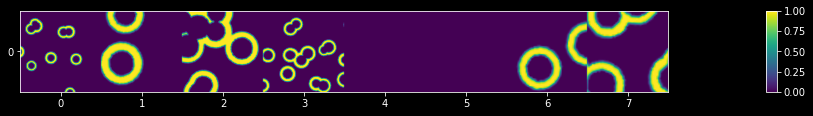

In [ ]:
imshow(source["source"], colorbar=True, bind_vminmax_01=False, unset_vminmax=True)

## Model Instantiation

In [ ]:
ca = ActiveModelClass()
# ca_metrics = appenDict()
ca.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    # loss="mse",
    # metrics=["mse", "mae", "acc"]
)

(8, 256, 256, 1)
tf.Tensor(0.11367703, shape=(), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 64  1792        ['source[0][0]']                 
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 84, 84, 64)   0           ['conv2d[0][0]']                 
                              

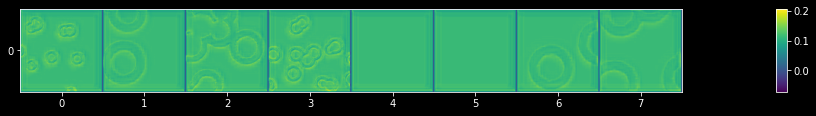

In [ ]:
if "MODEL_INSTANTIATION" in TEST_CONTEXTS:
    yhat = ca(source.repack()[0])
    print(yhat.shape)
    print(tf.reduce_mean(yhat))
    ca.summary()
    # print(ca.attention_layer.get_config())
    imshow(yhat, colorbar=True, bind_vminmax_01=False)

# Training and Visualization

In [ ]:
tf.keras.plot_model

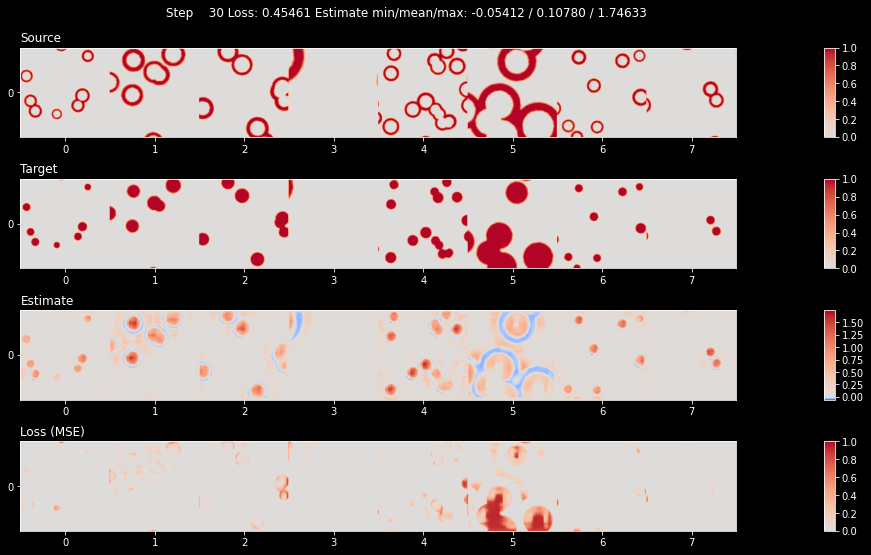

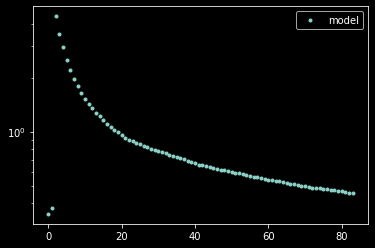

Source Shape: ({(8, 256, 256, None)}, 3)
Target Shape: (8, 256, 256, 1)
Mean Loss Shape: ()
Cell Loss Shape: (8, 256, 256, 1)
Y-Hat Shape    : (8, 256, 256, 1)


KeyboardInterrupt: ignored

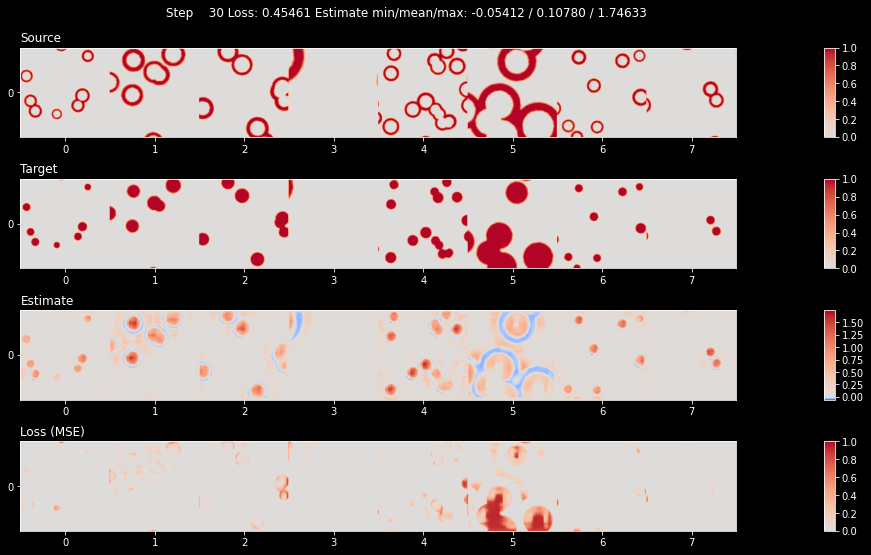

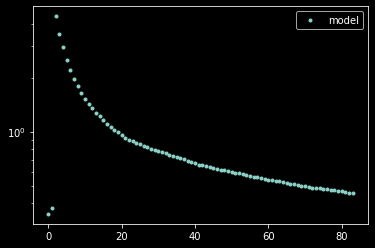

In [ ]:
##@title TV Loop
# tf.debugging.set_log_device_placement(False)
i = 0;
im_fig, im_axes = plt.subplots(4, 2, 
                                # squeeze=False, 
                                # sharex='col', 
                                linewidth=5,edgecolor="black",
                                # figsize=(FINAL_BATCHSIZE*2, 4*2), 
                                figsize=(FINAL_BATCHSIZE*(FIG_SCALE+COLORBAR_FRACTION), 4*FIG_SCALE + 1.6), 
                                constrained_layout=True, 
                                subplot_kw={},
                                gridspec_kw={"width_ratios": [FINAL_BATCHSIZE, 0.1]}
                               )

im_axes[0, 0].get_shared_x_axes().join(*im_axes[:, 0])

err_fig = plt.figure()
err_ax = err_fig.add_subplot(label="Loss")

for i in range(1000+1):
  try:
    x0 = data_iter.get_next()
  except tf.errors.OutOfRangeError:
    print("OORE")
    x0 = data_iter.get_next()
  
  source, target = split_data_to_x_y(x0)
  # print(source.shape)
  metrics = ca.train_step((source.repack()[0], target))
  ca_metrics.setdefault(ca.name, appenDict()).update(metrics)

  if i % 5 == 0:

    # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
    yhat = ca(source.repack()[0])
    cell_mse = tf.math.squared_difference(yhat, target)
    # cell_mse = ca.per_cell_mse(target, yhat)
    # loss = ca.compute_loss(source, target, yhat)
    loss = ca_metrics[ca.name]["loss"][-1]

    clear_output(wait=True)
    im_fig.suptitle(f"Step {i:5} Loss: {loss.numpy():2.5f} Estimate min/mean/max: {tf.reduce_min(yhat).numpy():2.5f} / {tf.reduce_mean(yhat).numpy():2.5f} / {tf.reduce_max(yhat).numpy():2.5f}")
    
    imshow(source.partialpack(unordered_keys="source"),ax=im_axes[0], title="Source",   colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=1), unset_vminmax=True)
    imshow(target,                                     ax=im_axes[1], title="Target",   colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=-1e-4, vcenter=0, vmax=1), unset_vminmax=True)
    imshow(yhat,                                       ax=im_axes[2], title="Estimate", colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vcenter=0))
    imshow(cell_mse,                                   ax=im_axes[3], title="Loss (MSE)",     colorbar=True, cmap="coolwarm", norm=colors.TwoSlopeNorm(vcenter=0))

    
    err_ax.clear()
    for run_name, run_metrics in ca_metrics.items():
      err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
    err_ax.set_yscale('log')
    err_ax.legend()
    display(im_fig)
    display(err_fig)

    print(f"Source Shape: {source.shapes()}")
    print(f"Target Shape: {target.shape}")
    print(f"Mean Loss Shape: {loss.shape}")
    print(f"Cell Loss Shape: {cell_mse.shape}")
    print(f"Y-Hat Shape    : {yhat.shape}")

In [ ]:
x0 = data_iter.get_next()
source, target = split_data_to_x_y(x0)
x, _ = source.repack()
x_first = x[0:1]
print(x_first.shape)
center_slice = np.s_[:, FINAL_PATCHSIZE//2, FINAL_PATCHSIZE//2, :]
with tf.GradientTape() as g:
    g.watch(x_first)
    yhat = ca(x_first)
    yhat_central = yhat[center_slice]
    dyc_dx = g.gradient(yhat_central, x_first)

dyc_dx.shape


    


(1, 256, 256, 3)


TensorShape([1, 256, 256, 3])

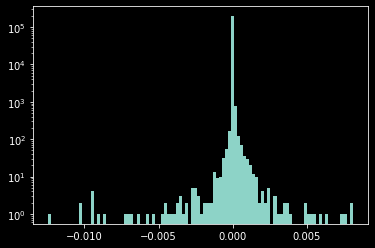

In [ ]:
_ = plt.hist(tf.reshape(dyc_dx, [-1]), bins=100, log=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  """Entry point for launching an IPython kernel.


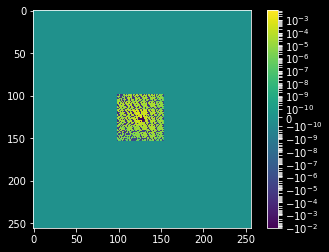

In [ ]:
plt.imshow(dyc_dx[0, :, :, 2], norm=colors.SymLogNorm(linthresh=1e-10))
plt.colorbar()

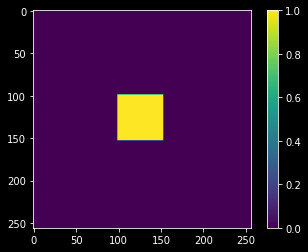

In [ ]:
plt.imshow(dyc_dx[0, :, :, 2] != 0)
plt.colorbar()